# Processing SST2 NEXAFS

## Imports

In [6]:
pip install --upgrade xarray zarr numcodecs

  Using cached zarr-2.16.1-py3-none-any.whl (206 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numcodecs
    Found existing installation: numcodecs 0.11.0
    Uninstalling numcodecs-0.11.0:
      Successfully uninstalled numcodecs-0.11.0
  Attempting uninstall: zarr
    Found existing installation: zarr 2.14.2
    Uninstalling zarr-2.14.2:
      Successfully uninstalled zarr-2.14.2
Note: you may need to restart the kernel to use updated packages.


In [25]:
## Imports
import pathlib
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.auto import tqdm
from scipy import optimize

sys.path.append('/nsls2/users/alevin/rsoxs_suite/misc_older_work/nexafs_analysis')
import nexafs_fxns as nf  # custom nexafs functions used in this notebook

## Define paths & sample name dictionary

In [26]:
# Define paths
propPath = pathlib.Path('/nsls2/data/sst/proposals/2023-2/pass-311130')
propPath = pathlib.Path('/nsls2/data/sst/proposals/2023-3/pass-313412')
peyPath = propPath.joinpath('SST1-NEXAFS-202310')
outPath = propPath.joinpath('processed_data')
zarrsPath = outPath.joinpath('zarrs')

sample_name_dict = {
    'PEY5': 'Y7_CB',
    'PEY11': 'Y7_CBCN',
    'PEY13': 'PM6-Y6_CBCN',
    'PEY14': 'PM6-Y6BO_CB',
    'PEY15': 'PM6-Y6BO_CBCN',
    'PEY16': 'PM6-Y7_CB',
    'PEY17': 'PM6-Y7_CBCN',
    'PEY18': 'PM6-Y7BO_CB',
    'PEY19': 'PM6-Y7BO_CBCN',
    'PEY24': 'PM6-Y6_CF',
    'PEY25': 'PM6-Y6_CFCN',
    'PEY26': 'PM6-Y6BO_CF',
    'PEY27': 'PM6-Y6BO_CFCN',
    'PEY28': 'PM6-Y7_CF',
    'PEY29': 'PM6-Y7_CFCN',
    'PEY30': 'PM6-Y7BO_CF',
    'PEY31': 'PM6-Y7BO_CFCN'
}

## Load raw nexafs chamber data files

### Specify paths / filenames / sample id's

In [27]:
# Specify paths, filenames, and unique sample id's
pey_list = sorted(peyPath.glob('PEY*_N*1'))
# pey_list = sorted(peyPath.glob('PEY*_C*'))
pey_fnames =  [f.name for f in pey_list]
sample_ids = sorted(set([fname.split('_')[0] for fname in pey_fnames]), key=lambda x: int(x[3:]))

# Specify diode paths
carbon_diode_path = peyPath.joinpath('DM8Diode_CNorm.9000')
nitrogen_diode_path = peyPath.joinpath('DM8Diode_NNorm.9000')

# For creating datasets:
column_names = ['energy', 'tey', 'i_ref', 'pey', 'i_0', 'm4c', 'dm8_diode', 'fy_csi']

### Load diode(s)

In [29]:
# Load first sample into DataArray -> Dataset
# diode_path = carbon_diode_path  # carbon
# didoe_name = 'carbon_didoe'  # carbon 

diode_path = nitrogen_diode_path  # nitrogen
didoe_name = 'nitrogen_didoe'  # nitrogen 
    
d = np.loadtxt(diode_path, skiprows=18)
energy = d[:,0]

diode_DS = xr.Dataset(data_vars = {
                    'tey': ('energy', d[:,1]),
                    'i_ref': ('energy', d[:,2]),
                    'pey': ('energy', d[:,3]),
                    'i_0': ('energy', d[:,4]),
                    'm4c': ('energy', d[:,5]),
                    'diode': ('energy', d[:,6]),
                    'fy_csi': ('energy', d[:,7])
                },
                coords = {'energy':energy})

# diode_DS.attrs['name'] = 'carbon_diode'  # carbon
# energies = np.linspace(275, 320, 6000)  # carbon

diode_DS.attrs['name'] = 'nitrogen_diode'  # nitrogen
energies = np.linspace(385, 419.5, 3000)  # nitrogen

diode_DS = diode_DS.interp({'energy':energies})

diode_DS

<xarray.Dataset>
Dimensions:  (energy: 3000)
Coordinates:
  * energy   (energy) float64 385.0 385.0 385.0 385.0 ... 419.5 419.5 419.5
Data variables:
    tey      (energy) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 nan
    i_ref    (energy) float64 0.2467 -0.0601 -0.3669 -0.6736 ... 426.6 426.4 nan
    pey      (energy) float64 0.9933 0.955 0.9166 0.8783 ... -0.9789 -0.9905 nan
    i_0      (energy) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 nan
    m4c      (energy) float64 -4.32 -4.435 -4.55 -4.665 ... 398.5 398.6 nan
    diode    (energy) float64 -8.52 -8.635 -8.75 -8.865 ... 567.1 567.3 nan
    fy_csi   (energy) float64 -0.6667 -0.4749 -0.2832 ... 3.237 3.271 nan
Attributes:
    name:     nitrogen_diode

### Load samples

In [30]:
# Load first sample into DataArray -> Dataset
nf_DS_sample_concat = []
for sample_id in tqdm(sample_ids):
    nf_DS_theta_concat = []
    for f in sorted(list(peyPath.glob(f'{sample_id}*_N*1'))):
        with f.open(mode='r') as file:
            lines = file.readlines()

        theta = int(lines[13].split('/')[1][-2:])
        sample_id = f.name.split('_')[0]
        # columns = lines[17].split()

        d = np.loadtxt(f, skiprows=18)
        energy = d[:,0]

        nf_DS = xr.Dataset(data_vars = {
                            'tey': ('energy', d[:,1]),
                            'i_ref': ('energy', d[:,2]),
                            'pey': ('energy', d[:,3]),
                            'i_0': ('energy', d[:,4]),
                            'm4c': ('energy', d[:,5]),
                            'diode': ('energy', d[:,6]),
                            'fy_csi': ('energy', d[:,7])
                        },
                        coords = {'energy':energy})

        nf_DS = nf_DS.expand_dims({'theta': [theta], 'sample_id': [sample_id]})

        # energies = np.linspace(275, 320, 6000)  # carbon
        energies = np.linspace(385, 419.5, 3000)  # nitrogen
        nf_DS = nf_DS.interp({'energy':energies})

        nf_DS_theta_concat.append(nf_DS)

    nf_DS = xr.concat(nf_DS_theta_concat, dim='theta')
    nf_DS_sample_concat.append(nf_DS)
    
nf_DS = xr.concat(nf_DS_sample_concat, dim='sample_id')
nf_DS = (nf_DS.assign_coords({'sample_name':('sample_id', [sample_name_dict[sample_id] for sample_id in nf_DS.sample_id.values]),
                        'cos_sq_theta': ('theta', ((np.cos(np.deg2rad(nf_DS.theta)))**2).data)})
        .swap_dims({'sample_id':'sample_name'}))
nf_DS

  0%|          | 0/2 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:       (theta: 3, sample_name: 2, energy: 3000)
Coordinates:
  * theta         (theta) int64 20 55 90
    sample_id     (sample_name) object 'PEY5' 'PEY11'
  * energy        (energy) float64 385.0 385.0 385.0 385.0 ... 419.5 419.5 419.5
  * sample_name   (sample_name) <U7 'Y7_CB' 'Y7_CBCN'
    cos_sq_theta  (theta) float64 0.883 0.329 3.749e-33
Data variables:
    tey           (theta, sample_name, energy) float64 1.172e+03 ... nan
    i_ref         (theta, sample_name, energy) float64 2.975e+03 ... nan
    pey           (theta, sample_name, energy) float64 302.3 302.2 ... 117.3 nan
    i_0           (theta, sample_name, energy) float64 492.1 492.1 ... 593.1 nan
    m4c           (theta, sample_name, energy) float64 1.782e+03 ... nan
    diode         (theta, sample_name, energy) float64 1.2 1.162 ... 0.2 nan
    fy_csi        (theta, sample_name, energy) float64 94.8 95.8 ... 82.0 nan

### Consruct full dataset & apply double-norm correction

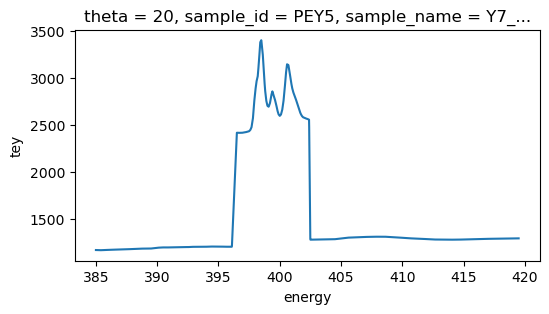

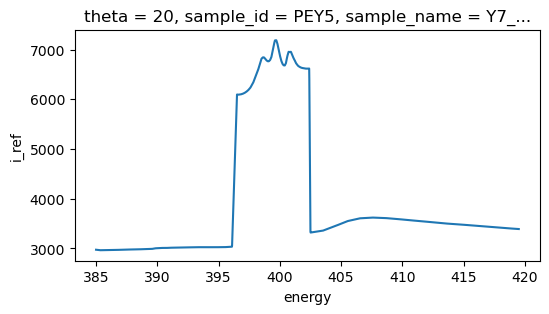

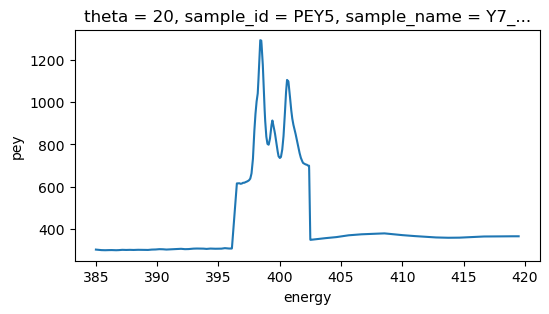

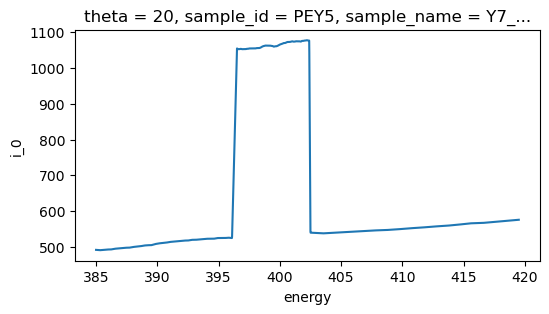

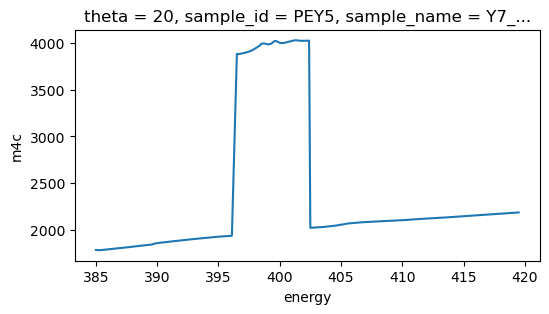

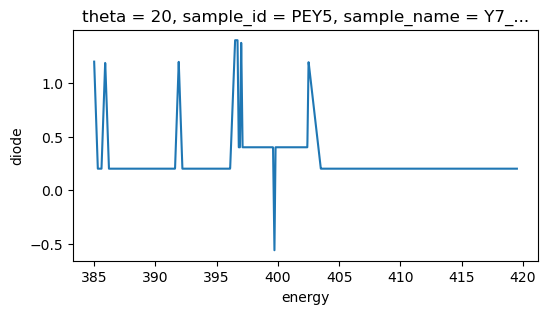

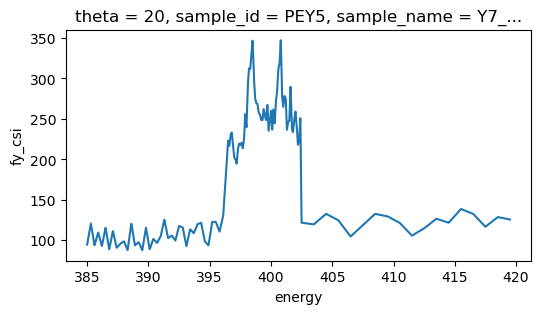

In [31]:
for data_var in nf_DS.data_vars:
    nf_DS.sel(theta=20, sample_name='Y7_CB')[data_var].plot(figsize=(6,3))
    plt.show()

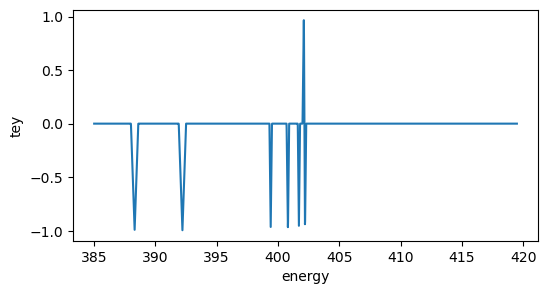

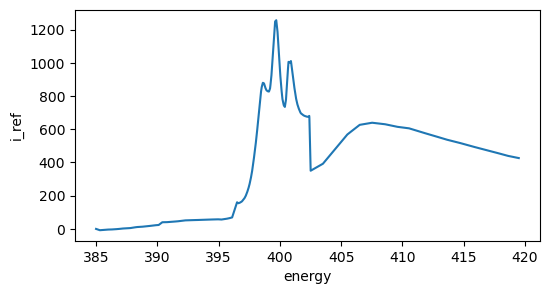

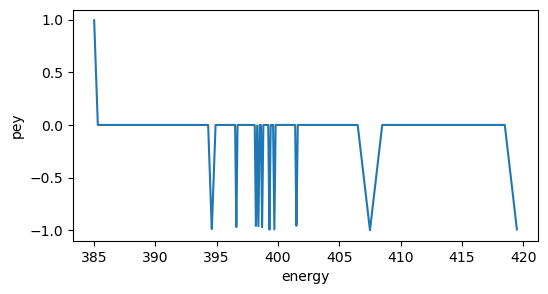

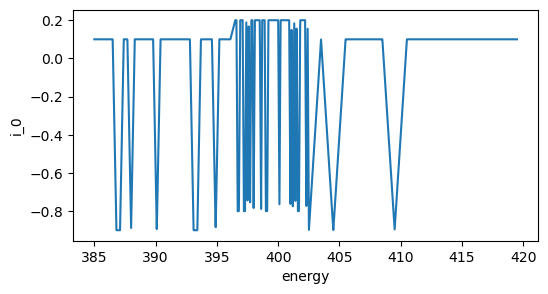

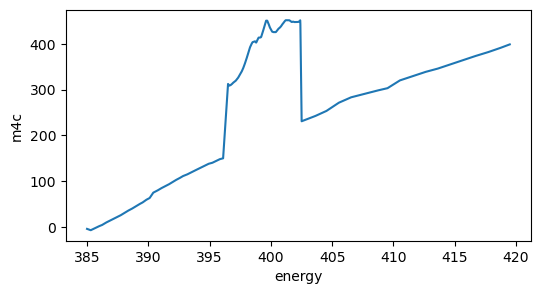

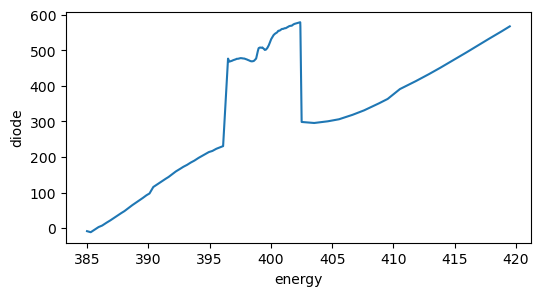

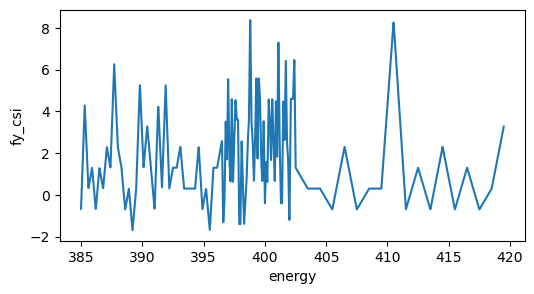

In [32]:
for data_var in diode_DS.data_vars:
    diode_DS[data_var].plot(figsize=(6,3))
    plt.show()

In [33]:
# Create nexafs dataset to export & apply/add double-norm-corrected data variable

plan_of_interest = 'nexafs_nitrogen'
DS = xr.Dataset(attrs={'name': plan_of_interest})

for nexafs_type in ['pey', 'tey', 'fy_csi']:
    DS[f'raw_{nexafs_type}'] = nf_DS[f'{nexafs_type}']
    DS['sample_i_ref'] = nf_DS['i_ref']
    DS['calib_i_ref'] = diode_DS['i_ref']
    # DS['calib_diode'] = diode_DS['m4c']
    DS['calib_diode'] = diode_DS['diode']
    DS[f'dnorm_{nexafs_type}'] = (DS[f'raw_{nexafs_type}'] / DS['sample_i_ref']) * (DS['calib_i_ref'] / DS['calib_diode'])

DS

<xarray.Dataset>
Dimensions:       (theta: 3, sample_name: 2, energy: 3000)
Coordinates:
  * theta         (theta) int64 20 55 90
    sample_id     (sample_name) object 'PEY5' 'PEY11'
  * energy        (energy) float64 385.0 385.0 385.0 385.0 ... 419.5 419.5 419.5
  * sample_name   (sample_name) <U7 'Y7_CB' 'Y7_CBCN'
    cos_sq_theta  (theta) float64 0.883 0.329 3.749e-33
Data variables:
    raw_pey       (theta, sample_name, energy) float64 302.3 302.2 ... 117.3 nan
    sample_i_ref  (theta, sample_name, energy) float64 2.975e+03 ... nan
    calib_i_ref   (energy) float64 0.2467 -0.0601 -0.3669 ... 426.6 426.4 nan
    calib_diode   (energy) float64 -8.52 -8.635 -8.75 -8.865 ... 567.1 567.3 nan
    dnorm_pey     (theta, sample_name, energy) float64 -0.002942 ... nan
    raw_tey       (theta, sample_name, energy) float64 1.172e+03 ... nan
    dnorm_tey     (theta, sample_name, energy) float64 -0.0114 0.002742 ... nan
    raw_fy_csi    (theta, sample_name, energy) float64 94.8 95.8 ... 82.0 nan
    dnorm_fy_csi  (theta, sample_name, energy) float64 -0.0009226 ... nan
Attributes:
    name:     nexafs_nitrogen

## Apply pre and post edge correction

In [34]:
# Apply pre and post-edge normalizations (more involved right now...):

for nexafs_type in ['pey', 'tey', 'fy_csi']:
    data_var = f'dnorm_{nexafs_type}'

    # Carbon
    # pre_edge_energy_slice = slice(276, 283)  # carbon  
    # post_edge_energy_slice = slice(305, 320)

    # Nitrogen
    pre_edge_energy_slice = slice(392, 397.4)  # nitrogen
    post_edge_energy_slice = slice(403, 404)  # nitrogen
    
    # pre_edge_energy, post_edge_energy = [395, 430] # nitrogen
    # pre_edge_energy, post_edge_energy = [525, 555] # oxygen
    # pre_edge_energy, post_edge_energy = [680, 720] # oxygen


    # First generate list of corrected spectra
    pre_corr_list = []
    full_corr_list = []
    for sample_name in DS.sample_name.values:
        for theta in DS.theta.values:
            # Linear fit for pre-edge region
            if nexafs_type == 'fy_csi':
                pre_edge_mean = float(DS[data_var].sel(sample_name=sample_name, theta=theta, 
                                                       energy=pre_edge_energy_slice).mean(dim="energy"))
                # display(pre_edge_mean)
                pre_corr_DA = (DS[data_var].sel(sample_name=sample_name, theta=theta)) - pre_edge_mean
            else:
                # coefficients = np.polyfit(DS.energy.where(DS.energy<pre_edge_energy, drop=True), 
                #                           (DS['dnorm_trmsn']).where(DS.energy<pre_edge_energy, drop=True).sel(sample_name=sample_name, theta=theta), 1)   
                coefficients = np.polyfit(DS.energy.sel(energy=pre_edge_energy_slice), 
                                          DS[data_var].sel(energy=pre_edge_energy_slice, sample_name=sample_name, theta=theta), 
                                          1)
                y_fit = np.polyval(coefficients, DS.energy)
                pre_corr_DA = (DS[data_var].sel(sample_name=sample_name, theta=theta)) - y_fit
                
            pre_corr_DA = pre_corr_DA.expand_dims({'sample_name': [pre_corr_DA.sample_name.data],
                                                   'theta': [pre_corr_DA.theta.data]})
            pre_corr_DA = pre_corr_DA.assign_coords({'sample_id': ('sample_name', [pre_corr_DA.sample_id.data])})     

            pre_corr_list.append(pre_corr_DA)

            # Post edge
            # post_edge_mean = corr_DA.where(DS.energy>post_edge_energy, drop=True).mean(dim="energy")
            post_edge_mean = pre_corr_DA.sel(energy=post_edge_energy_slice).mean(dim="energy")
            full_corr_DA = pre_corr_DA / np.abs(float(post_edge_mean))        

            full_corr_list.append(full_corr_DA)

    # Now reconstruct full dataarray and add to dataset created in prior cell
    corr_names = [f'pre_corr_{nexafs_type}', f'full_corr_{nexafs_type}']

    for i, corr_list in enumerate([pre_corr_list, full_corr_list]):
    # corr_names = ['pre_corr_trmsn']
    # for i, corr_list in enumerate([pre_corr_list]):
        # First group by sample_name
        grouped_by_sample = {}
        for corr_DA in corr_list:
            sample_name = corr_DA.sample_name.values[0]
            if sample_name not in grouped_by_sample:
                grouped_by_sample[sample_name] = []
            grouped_by_sample[sample_name].append(corr_DA)

        # Concatenate by theta for each sample_name
        concat_by_theta = {}
        for sample_name, group in grouped_by_sample.items():
            concat_by_theta[sample_name] = xr.concat(group, dim="theta")

        # Finally, concatenate the result along the sample_name dimension
        DS[corr_names[i]] = xr.concat(list(concat_by_theta.values()), dim="sample_name")
    
DS

<xarray.Dataset>
Dimensions:           (theta: 3, sample_name: 2, energy: 3000)
Coordinates:
  * theta             (theta) int64 20 55 90
    sample_id         (sample_name) object 'PEY5' 'PEY11'
  * energy            (energy) float64 385.0 385.0 385.0 ... 419.5 419.5 419.5
  * sample_name       (sample_name) object 'Y7_CB' 'Y7_CBCN'
    cos_sq_theta      (theta) float64 0.883 0.329 3.749e-33
Data variables: (12/15)
    raw_pey           (theta, sample_name, energy) float64 302.3 302.2 ... nan
    sample_i_ref      (theta, sample_name, energy) float64 2.975e+03 ... nan
    calib_i_ref       (energy) float64 0.2467 -0.0601 -0.3669 ... 426.4 nan
    calib_diode       (energy) float64 -8.52 -8.635 -8.75 ... 567.1 567.3 nan
    dnorm_pey         (theta, sample_name, energy) float64 -0.002942 ... nan
    raw_tey           (theta, sample_name, energy) float64 1.172e+03 ... nan
    ...                ...
    pre_corr_pey      (sample_name, theta, energy) float64 -0.02447 ... nan
    full_corr_pey     (sample_name, theta, energy) float64 -0.2406 ... nan
    pre_corr_tey      (sample_name, theta, energy) float64 -0.09818 ... nan
    full_corr_tey     (sample_name, theta, energy) float64 -0.2749 ... nan
    pre_corr_fy_csi   (sample_name, theta, energy) float64 -0.01215 ... nan
    full_corr_fy_csi  (sample_name, theta, energy) float64 -0.3261 ... nan
Attributes:
    name:     nexafs_nitrogen

  0%|          | 0/2 [00:00<?, ?it/s]

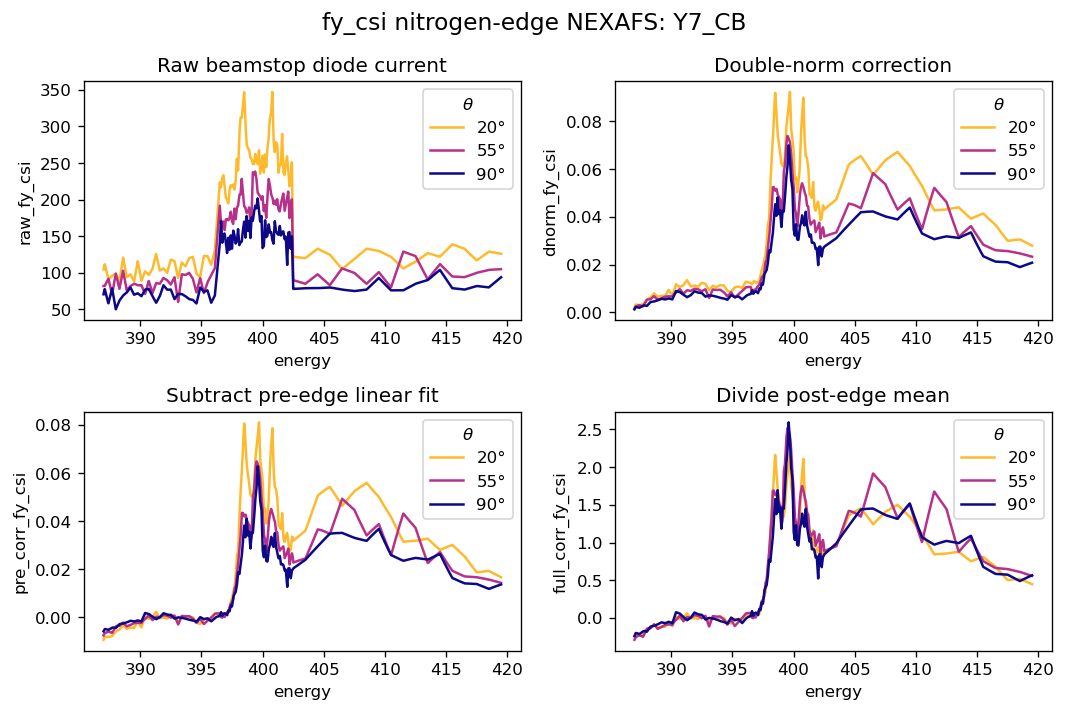

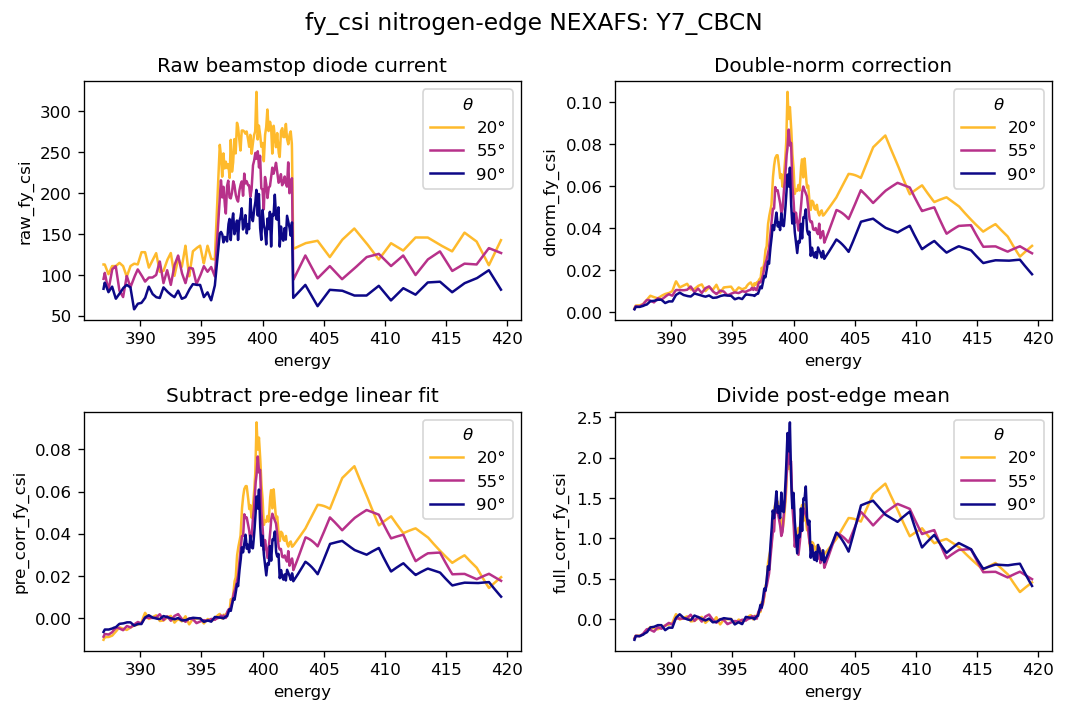

In [36]:
# DS = loaded_DS.copy()
edge = 'nitrogen'
nexafs_type = 'fy_csi'

energy_min = 387  # nitrogen
energy_max = 419.5  # nitrogen

# energy_min = 275
# energy_max = 320

energy_slice = slice(energy_min, energy_max)
# energy_slice = slice(None, None)

# energy_slice = slice(250,350) # carbon
# energy_slice = slice(370, 440) # nitrogen
# energy_slice = slice(396, 405) # nitrogen

# Create the colormap
colors = plt.cm.plasma_r(np.linspace(0.15, 1, len(DS.theta)))
# colors = plt.cm.plasma(np.linspace(0, 0.85, len(DS.theta)))


for sample_name in tqdm(DS.sample_name.values):
    fig, axs = plt.subplots(2, 2)
    fig.set(size_inches=(9, 6), dpi=120, tight_layout=True)
    fig.suptitle(f'{nexafs_type} {edge}-edge NEXAFS: {sample_name}', fontsize=14)
    # fig.suptitle(f'Transmission {edge}-edge NEXAFS: {sample_name}', fontsize=14)
    # fig.suptitle(f'TEY {edge}-edge NEXAFS: {sample_name}', fontsize=14)

    for i, theta_val in enumerate(DS.theta.values):
        sliced_DS = DS.sel(energy=energy_slice, sample_name=sample_name, theta=theta_val)
        sliced_DS[f'raw_{nexafs_type}'].plot.line(ax=axs[0,0], color=colors[i], label=f'{int(theta_val)}°')
        sliced_DS[f'dnorm_{nexafs_type}'].plot.line(ax=axs[0,1], color=colors[i], label=f'{int(theta_val)}°')
        sliced_DS[f'pre_corr_{nexafs_type}'].plot.line(ax=axs[1,0], color=colors[i], label=f'{int(theta_val)}°')
        sliced_DS[f'full_corr_{nexafs_type}'].plot.line(ax=axs[1,1], color=colors[i], label=f'{int(theta_val)}°')
        # ((sliced_DS[f'full_corr_{nexafs_type}'] / float(DS[f'full_corr_{nexafs_type}'].sel(
        #                                           sample_name=sample_name, theta=theta_val, energy=slice(402,404)).mean('energy')))
        #  .plot.line(ax=axs[1,1], color=colors[i], label=f'{int(theta_val)}°'))
    
    axs[0,0].set(title='Raw beamstop diode current')
    axs[0,1].set(title='Double-norm correction')
    axs[1,0].set(title='Subtract pre-edge linear fit')
    axs[1,1].set(title='Divide post-edge mean')
    # axs[1,1].set(title='Divide post-edge mean & subtract SiN spectra')

    # Optionally, add legends
    axs[0,0].legend(title=r"$\theta$", loc='upper right')
    axs[0,1].legend(title=r"$\theta$", loc='upper right')
    axs[1,0].legend(title=r"$\theta$", loc='upper right')
    axs[1,1].legend(title=r"$\theta$", loc='upper right')
    
    plt.show()
    # fig.savefig(outPath.joinpath(f'nexafs_plots/{nexafs_type}_{edge}_nexafs_all', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)
    # fig.savefig(outPath.joinpath(f'nexafs_plots/nf_chamber_{nexafs_type}_{edge}_nexafs_all', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)
    plt.close('all')

### Optionally save & load zarr

In [38]:
# Define chunk sizes as the full shape of each variable
# Need to do this if zarr/xarray is bugging out(?)
encoding = {var: {'chunks': DS[var].shape} for var in DS.variables}

plan_of_interest = f'nexafs_{edge}'
DS.to_zarr(zarrsPath.joinpath(f'PEY_{plan_of_interest}.zarr'), mode='w', encoding=encoding)

In [24]:
# loaded_DS = xr.open_zarr(zarrsPath.joinpath('PEY_nexafs_carbon.zarr'))
loaded_DS = xr.open_zarr(zarrsPath.joinpath('PEY_nexafs_nitrogen.zarr'))
# loaded_DS = xr.open_zarr(zarrsPath.joinpath('testing123.zarr'))


DS = loaded_DS.compute()
DS

<xarray.Dataset>
Dimensions:        (energy: 3000, theta: 3, sample_name: 2)
Coordinates:
    cos_sq_theta   (theta) float64 0.883 0.329 3.749e-33
  * energy         (energy) float64 385.0 385.0 385.0 ... 419.5 419.5 419.5
    sample_id      (sample_name) object 'PEY5' 'PEY11'
  * sample_name    (sample_name) object 'Y7_CB' 'Y7_CBCN'
  * theta          (theta) int64 20 55 90
Data variables:
    calib_diode    (energy) float64 -4.32 -4.435 -4.55 ... 398.5 398.6 nan
    calib_i_ref    (energy) float64 0.2467 -0.0601 -0.3669 ... 426.6 426.4 nan
    dnorm_pey      (theta, sample_name, energy) float64 -0.005802 ... nan
    dnorm_tey      (theta, sample_name, energy) float64 -0.02249 ... nan
    full_corr_pey  (sample_name, theta, energy) float64 -0.3692 -0.3077 ... nan
    full_corr_tey  (sample_name, theta, energy) float64 -0.4237 -0.3552 ... nan
    pre_corr_pey   (sample_name, theta, energy) float64 -0.04301 ... nan
    pre_corr_tey   (sample_name, theta, energy) float64 -0.172 -0.1443 ... nan
    raw_pey        (theta, sample_name, energy) float64 302.3 302.2 ... nan
    raw_tey        (theta, sample_name, energy) float64 1.172e+03 ... nan
    sample_i_ref   (theta, sample_name, energy) float64 2.975e+03 ... nan
Attributes:
    name:     nexafs_nitrogen

## Plotting

### NEXAFS all

In [ ]:
DS

In [ ]:
energy_min = 275
energy_max = 310
energy_slice = slice(energy_min, energy_max) 

# Create the colormap
colors = plt.cm.plasma_r(np.linspace(0.15, 1, len(DS.theta)))

for sample_name in tqdm(DS.sample_name.values):
    fig, axs = plt.subplots(2, 2)
    fig.set(size_inches=(9, 6), dpi=120, tight_layout=True)
    fig.suptitle(f'PEY carbon-edge NEXAFS: {sample_name}', fontsize=14)

    for i, theta_val in enumerate(DS.theta.values):
        if sample_name=='PM6-Y6_Si' and theta_val==90:
            sliced_DS = DS.sel(energy=energy_slice, sample_name=sample_name, theta=theta_val)
            sliced_DS['pey'].plot.line(ax=axs[0,0], color=colors[i], label=f'{int(theta_val)}°')
            sliced_DS['i_0'].plot.line(ax=axs[0,1], color=colors[i], label=f'{int(theta_val)}°')
            sliced_DS['pre_corr_pey'].plot.line(ax=axs[1,0], color=colors[i], label=f'{int(theta_val)}°') 
            # sliced_DS['full_corr_pey'].plot.line(ax=axs[1,1], color=colors[i], label=f'{int(theta_val)}°')
        elif sample_name=='PM7-Y7_Si' and theta_val==55:
            sliced_DS = DS.sel(energy=energy_slice, sample_name=sample_name, theta=theta_val)
            sliced_DS['pey'].plot.line(ax=axs[0,0], color=colors[i], label=f'{int(theta_val)}°')
            # sliced_DS['i_0'].plot.line(ax=axs[0,1], color=colors[i], label=f'{int(theta_val)}°')
            sliced_DS['pre_corr_pey'].plot.line(ax=axs[1,0], color=colors[i], label=f'{int(theta_val)}°')   
            sliced_DS['full_corr_pey'].plot.line(ax=axs[1,1], color=colors[i], label=f'{int(theta_val)}°')
        else:
            sliced_DS = DS.sel(energy=energy_slice, sample_name=sample_name, theta=theta_val)
            sliced_DS['pey'].plot.line(ax=axs[0,0], color=colors[i], label=f'{int(theta_val)}°')
            sliced_DS['i_0'].plot.line(ax=axs[0,1], color=colors[i], label=f'{int(theta_val)}°')
            sliced_DS['pre_corr_pey'].plot.line(ax=axs[1,0], color=colors[i], label=f'{int(theta_val)}°')
            sliced_DS['full_corr_pey'].plot.line(ax=axs[1,1], color=colors[i], label=f'{int(theta_val)}°')
    
    axs[0,0].set(title='Raw beamstop diode current')
    axs[0,1].set(title='I0 (gold mesh); missing calibration diode')
    axs[1,0].set(title='Subtract pre-edge linear fit')
    axs[1,1].set(title='Divide by post-edge mean')

    # Optionally, add legends
    axs[0,0].legend(title=r"$\theta$")
    axs[0,1].legend(title=r"$\theta$")
    axs[1,0].legend(title=r"$\theta$")
    axs[1,1].legend(title=r"$\theta$")
    
    plt.show()
    # fig.savefig(outPath.joinpath('nexafs_plots/pey_nexafs_all', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)
    plt.close('all')

### NEXAFS single data variable

In [ ]:
energy_min = 282
energy_max = 292
energy_slice = slice(energy_min, energy_max)

for sample_name in tqdm(DS.sample_name.values):
    colors = plt.cm.plasma_r(np.linspace(0.15,1,len(DS.theta)))
    fig, ax = plt.subplots(figsize=(7,3.5), dpi=120, tight_layout=True)
    for i, theta_val in enumerate(DS.theta.values):
        if sample_name=='PM6-Y6_Si' and theta_val==90:
            pass
        else:
            (DS['full_corr_pey'].sel(sample_name=sample_name, theta=theta_val, energy=energy_slice)
                      .plot.line(ax=ax, color=colors[i], label=f'{int(theta_val)}°'))

    fig.suptitle(f'Raw PEY NEXAFS: {sample_name}', x=0.53)
    ax.set(title='Pre-edge linear fit subtracted & post-edge mean normalized', xlabel='X-ray Energy [eV]', ylabel='Normalized NEXAFS [arb. units]')
    ax.legend(title=r'$\theta$')
    # fig.savefig(outPath.joinpath(f'nexafs_plots/pey_nexafs_full_corr', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)
    plt.show()
    plt.close('all')

### Molecular tilt fit

In [ ]:
# Run Stöhr 9.16a tilt fit on energy region of NEXAFS
energy_min = 284
energy_max = 286

# sample_name = 'PM6_3000_dSiN_R'
for sample_name in DS.sample_name.values:
    nf_DA = DS['full_corr_pey'].sel(sample_name=sample_name)

    pi_peak_areas = nf.int_area(energy_min, energy_max, nf_DA)

    bnds = [(0, 90), (0, 20)]
    res = optimize.differential_evolution(
        nf.mse_line_tilt, bounds=bnds, args=(pi_peak_areas, nf_DA.theta.values), tol=1e-6)

    alpha, const = res.x

    # Plot intensities from Stöhr 9.16a (scaled with fitted constant) as line
    # along with measured pi_peak_areas, x-axis is cos_sq_theta:
    fig, axs = plt.subplots(ncols=2, figsize=(10,4.5), dpi=120, tight_layout=True)
    fig.suptitle(str(nf_DA.sample_name.values), y=1.03, fontsize=14)
    axs[0].plot(nf_DA.cos_sq_theta.values[:], const * nf.i_nexafs(alpha, nf_DA.theta.values[:]),
            marker='o', label=f'Stöhr 9.16a: ($\\alpha$={np.round(alpha,2)}, const={np.round(const,2)})',
            clip_on=False, zorder=3)
    axs[0].plot(nf_DA.cos_sq_theta.values[:], pi_peak_areas[:], marker='o',
            label=f'NEXAFS integrated areas', clip_on=False, zorder=4)
    axs[0].set(title='Peak fit', xlabel=r'$cos^2(\theta)$', ylabel='Intensity [arb. units]')
    axs[0].set_xticks(nf_DA.cos_sq_theta.values, minor=True)
    axs[0].set_xlim(left=0)
    axs[0].legend()

    # Add secondary axis showing theta values:
    def forward(x):
        return np.arccos(np.sqrt(x)) * 180 / np.pi

    def inverse(x):
        return np.cos(x * np.pi / 180)**2

    ax2 = axs[0].secondary_xaxis(-0.23, functions=(forward, inverse))
    ax2.set(xlabel=r'$\theta$ [$\degree$]')
    ax2.set_xticks(nf_DA.theta.values)


    colors = plt.cm.plasma_r(np.linspace(0.15,1,len(nf_DA.theta)))
    for i, theta_val in enumerate(nf_DA.theta.values):
        (nf_DA.sel(theta=theta_val, energy=slice(282, 292))
               .plot.line(ax=axs[1], color=colors[i], label=f'{int(theta_val)}°'))

    axs[1].axvline(energy_min, color='grey')
    axs[1].axvline(energy_max, color='grey')
    axs[1].set(title='NEXAFS', xlabel='X-ray Energy [eV]', ylabel='Normalized NEXAFS [arb. units]')
    axs[1].legend(title=r'$\theta$ [$\degree$]', loc='upper left')

    fig.savefig(outPath.joinpath('nexafs_plots/pey_tilt_fit', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)

    plt.show()
    plt.close('all')

### Calculate optical constants & binary contrasts

#### Define functions & chemical formulas 

In [ ]:
# Define function to calculate binary contrast
def binary_contrast(n1, n2=None):
    if n2 is None:
        #second component is vacuum
        n2 = xr.zeros_like(n1)
    else:
        #second is interpolated to match the energy array of the first component.  
        n2 = n2.interp(energy=n1.energy)
    return n1.energy**4 * ((n1.delta-n2.delta)**2 + (n1.beta-n2.beta)**2)

# Add chemical formulas as coordinate along 'sample_name' dimension
# Define necessary formula stoichiometries
Y6_formula = 'C82H86F4N8O2S5'
Y7_formula = 'C82H86Cl4N8O2S5'
PM6_formula = 'C68H76F2O2S8'
PM7_formula = 'C68H76Cl2O2S8'

# Make dictionary of sample_name keys and formula values
# chemical_formulas = {
#     'BareSiN_R': 'SiN',
#     'PM6_3000_dSiN_R': PM6_formula,
#     'PM7-Y6_3000_dSiN_R': PM7_formula+Y6_formula,
#     'Y6_3000_dSiN_R': Y6_formula,
#     'Y7_3000_dSiN_R': Y7_formula,
#     'PM7_3000_dSiN_R': PM7_formula,
#     'PM6-Y6_3000_dSiN_R': PM6_formula+Y6_formula,
#     'PM6-Y7_3000_dSiN_R': PM6_formula+Y7_formula,
#     'PM7-Y7_3000_dSiN_R': PM7_formula+Y7_formula,
#     'Y6_2000_dSiN_R': Y6_formula,
#     'Y7_2000_dSiN_R': Y7_formula
# }

chemical_formulas = {
    'PM6_Si': PM6_formula,
    'PM7-Y6_Si': PM7_formula+Y6_formula,
    'Y6_Si': Y6_formula,
    'Y7_Si': Y7_formula,
    'PM7_Si': PM7_formula,
    'PM6-Y6_Si': PM6_formula+Y6_formula,
    'PM6-Y7_Si': PM6_formula+Y7_formula,
    'PM7-Y7_Si': PM7_formula+Y7_formula,
    'A1_Si': Y6_formula,
    'A2_Si': Y6_formula,
    'A3_Si': Y6_formula,
}

# Define function to take iterable of names and return list corresponding of formulas
def names2formula(names):
    formulas = []
    for name in names:
        formula = chemical_formulas[name]
        formulas.append(formula)
    return formulas

# Assign coordinate
DS = DS.assign_coords({'chemical_formula': ('sample_name', names2formula(DS.sample_name.values))})
DS

#### Generate optical constants dataset

In [ ]:
# Calculate optical constants via kkcalc
# Also calculate vacuum contrast
nexafs_type = 'pey'

n_list = []
for sample_name in tqdm(DS.sample_name.values):
    nf_DA = DS[f'full_corr_{nexafs_type}'].sel(sample_name=sample_name)
    chemical_formula = str(nf_DA.chemical_formula.values)
    n = nf.run_kkcalc_a(nf_DA, x_min=280, x_max=305, chemical_formula=chemical_formula, density=1.1)
    n = n.expand_dims({'sample_name':[sample_name]})
    n_list.append(n)
    
n_DS = xr.concat(n_list, dim='sample_name')
n_DS = n_DS.swap_dims({'cos_sq_theta':'theta'})
n_DS['vacuum_contrast'] = binary_contrast(n_DS)
n_DS

#### Plot optical constants and vacuum contrasts

In [ ]:
outPath

In [ ]:
# Plot optical constants and vacuum contrast for each sample 

# Set energy bounds and theta
nexafs_type = 'pey'
energy_min = 280
energy_max = 310
energy_slice = slice(energy_min, energy_max) # carbon
theta = 55

# Plotting loop
for sample_name in tqdm(n_DS.sample_name.values):
    fig, axs = plt.subplots(ncols=2, figsize=(12,4), tight_layout=True)
    fig.suptitle(f'{sample_name}: magic angle optical constants & vacuum contrast from PEY NEXAFS', fontsize=14, x=0.53)
    n_DS['delta'].sel(sample_name=sample_name, theta=theta, energy=energy_slice).plot.line(ax=axs[0], label=r'$\delta$')
    n_DS['beta'].sel(sample_name=sample_name, theta=theta, energy=energy_slice).plot.line(ax=axs[0], label=r'$\beta$')
    n_DS['vacuum_contrast'].sel(sample_name=sample_name, theta=theta, energy=energy_slice).plot.line(ax=axs[1], yscale='log')
    axs[0].legend()
    axs[0].set(title=r'Optical Constants, $\theta = 55°$', xlabel='X-ray energy [eV]', ylabel='Optical Constants Value [arb. units]')
    axs[1].set(title=r'Vacuum Binary Contrast, $\theta = 55°$', xlabel='X-ray energy [eV]', ylabel='Contrast [arb. units]')
    fig.savefig(outPath.joinpath(f'nexafs_plots/{nexafs_type}_carbon_magic_constants', f'{sample_name}_energy{energy_min}-{energy_max}.png'), dpi=120)
    plt.show()
    plt.close('all')

#### Plot binary contrasts

In [ ]:
# Define sample_name pairs to plot binary contrast for
# pairs = [
#     ('PM6_3000_dSiN_R', 'Y6_3000_dSiN_R'),
#     ('PM6_3000_dSiN_R', 'Y6_2000_dSiN_R'),    
#     ('PM6_3000_dSiN_R', 'Y7_3000_dSiN_R'),    
#     ('PM6_3000_dSiN_R', 'Y7_2000_dSiN_R'),    
#     ('PM7_3000_dSiN_R', 'Y6_3000_dSiN_R'),
#     ('PM7_3000_dSiN_R', 'Y6_2000_dSiN_R'),    
#     ('PM7_3000_dSiN_R', 'Y7_3000_dSiN_R'),    
#     ('PM7_3000_dSiN_R', 'Y7_2000_dSiN_R') 
# ]

pairs = [
    ('PM6_Si', 'Y6_Si'),
    ('PM6_Si', 'Y7_Si'),    
    ('PM7_Si', 'Y6_Si'),
    ('PM7_Si', 'Y7_Si'),    
]

# Set energy bounds and select theta
nexafs_type = 'pey'
energy_min = 282
energy_max = 292
energy_slice = slice(energy_min, energy_max)
theta = 55

# Plotting loop
for pair in tqdm(pairs):
    fig, ax = plt.subplots(figsize=(7,4), dpi=120, tight_layout=True)
    (binary_contrast(n_DS.sel(sample_name=pair[0]), n_DS.sel(sample_name=pair[1]))
     .sel(theta=theta, energy=energy_slice)
     .plot.line(ax=ax, yscale='log'))
    ax.set(title=f'Magic angle ($\\theta = 55°$) binary contrast: {pair[0]}:{pair[1]}', ylabel='Contrast [arb. units]', xlabel='X-ray energy [eV]')
    plt.show()
    fig.savefig(outPath.joinpath(f'nexafs_plots/{nexafs_type}_magic_binary_contrasts', f'{pair[0]}-{pair[1]}_energy{energy_min}-{energy_max}.png'), dpi=120)
    plt.close('all')